In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_wine

%matplotlib inline

In [21]:
plt.rcParams['figure.figsize'] = (10, 7)

In [11]:
# Read the dataset

wine_data = load_wine()

wine_df = pd.DataFrame(
    data = wine_data.data,
    columns = wine_data.feature_names
)

wine_df['target'] = wine_data.target

In [13]:
wine_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


<Axes: xlabel='features', ylabel='value'>

/opt/anaconda3/lib/python3.12/site-packages/seaborn/categorical.py:3399: UserWarning: 8.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


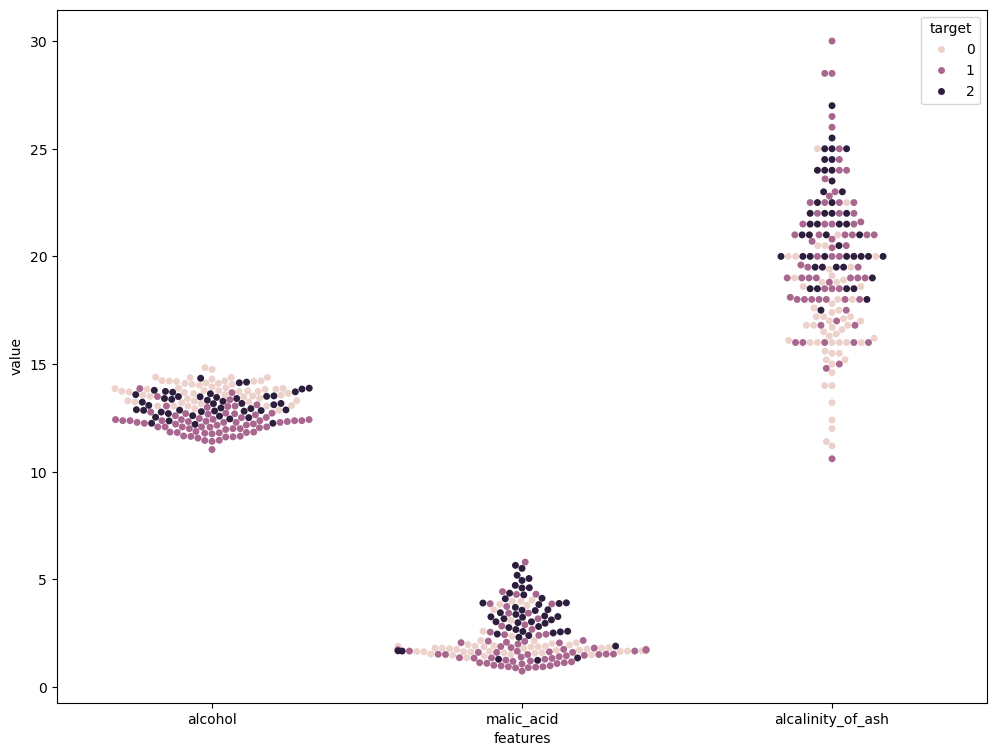

In [15]:
from seaborn import swarmplot

data_to_plot = pd.melt(wine_df[['alcohol', 'malic_acid', 'alcalinity_of_ash', 'target']],
                      id_vars = 'target',
                      var_name = 'features',
                      value_name = 'value')

swarmplot(data = data_to_plot, x = 'features', y = 'value', hue = 'target')

In [17]:
wine_df['target'].value_counts()

target
1    71
0    59
2    48
Name: count, dtype: int64

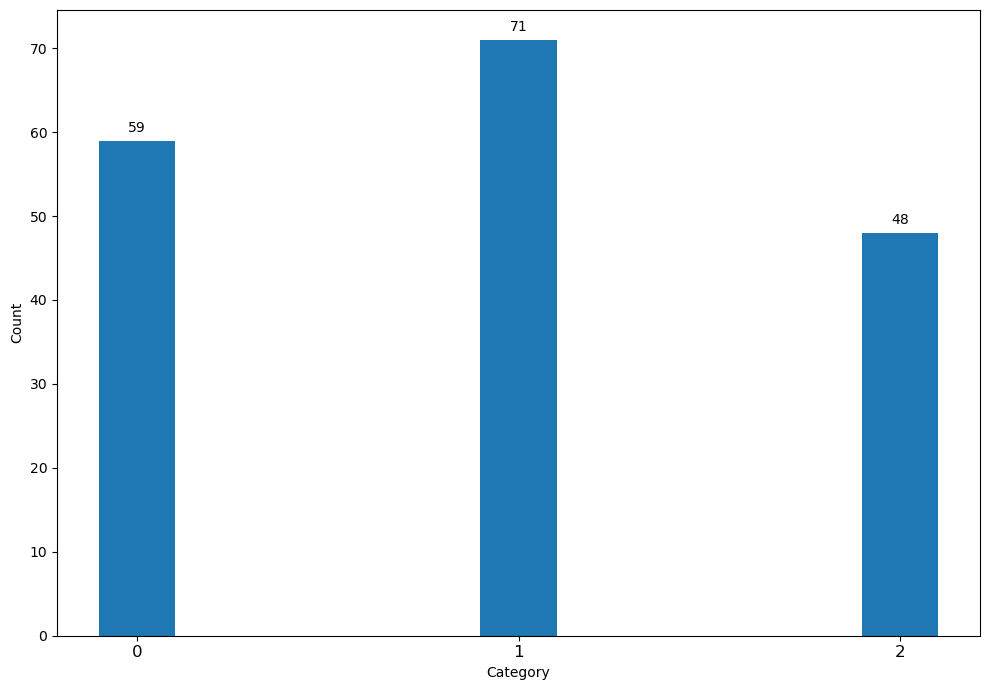

In [25]:
fig, ax = plt.subplots()

x = [0, 1, 2]
y = [59, 71, 48]

ax.bar(x, y, width = 0.2)
ax.set_xlabel('Category')
ax.set_ylabel('Count')
ax.set_xticks([0, 1, 2])
ax.set_xticklabels([0, 1, 2], fontsize = 12)


for index, value in enumerate(y):
    plt.text(x = int(index), y = value+1, s = str(value), ha = 'center')

plt.tight_layout()